In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
import random as r
import numpy as np
r.seed(100)

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#Show the whole arrays 
np.set_printoptions(threshold=np.inf)
#Resize matplotlib output
plt.figure(figsize=(20,7))
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<Figure size 1440x504 with 0 Axes>

In [2]:
from collections import Counter
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:

from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix   
from sklearn.preprocessing import LabelEncoder

import re
from time import time

In [5]:
from IPython.display import display

# 1. Inital data exploration

In [6]:
#laod the data
df = pd.read_csv("..\\diabetic_data.csv")
# Strip the whitespaces from the dataframe header
df.rename(columns=lambda x: x.strip(), inplace=True)

In [7]:
#dataset structure
print(df.shape)

(101766, 50)


In [8]:
#dataset head
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
#Replace all "?" values with NONE
df.replace("?",np.nan, inplace = True)

In [10]:
#Data structure and feature types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [11]:
#basic statistics
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000,101766.000,101766.000,101766.000,101766.000,101766.000,101766.000,101766.000,101766.000,101766.000,101766.000,101766.000,101766.000
mean,165201645.623,54330400.695,2.024,3.716,5.754,4.396,43.096,1.340,16.022,0.369,0.198,0.636,7.423
std,102640295.983,38696359.347,1.445,5.280,4.064,2.985,19.674,1.706,8.128,1.267,0.930,1.263,1.934
min,12522.000,135.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000
25%,84961194.000,23413221.000,1.000,1.000,1.000,2.000,31.000,0.000,10.000,0.000,0.000,0.000,6.000
50%,152388987.000,45505143.000,1.000,1.000,7.000,4.000,44.000,1.000,15.000,0.000,0.000,0.000,8.000
75%,230270887.500,87545949.750,3.000,4.000,7.000,6.000,57.000,2.000,20.000,0.000,0.000,1.000,9.000
max,443867222.000,189502619.000,8.000,28.000,25.000,14.000,132.000,6.000,81.000,42.000,76.000,21.000,16.000


In [12]:
#dataset head
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [13]:
#Target Variable distribution
df["readmitted"].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

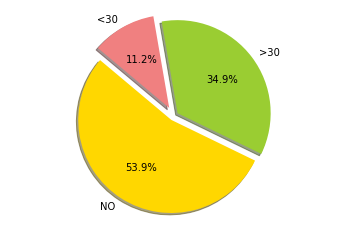

In [14]:
#Target Variable distribution
labels = ['NO', '>30' ,'<30']
sizes = df["readmitted"].value_counts()
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.05, 0.05, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# 2. Identifying outliers, missing values, or human error 

In [15]:
#count missing values in the data frame
nonFrame = pd.DataFrame(df.isnull().sum(axis=0)).reset_index()
new_names = ["FeatureName","Count"]
nonFrame.columns = new_names

In [16]:
print(nonFrame)

                 FeatureName  Count
0               encounter_id      0
1                patient_nbr      0
2                       race   2273
3                     gender      0
4                        age      0
5                     weight  98569
6          admission_type_id      0
7   discharge_disposition_id      0
8        admission_source_id      0
9           time_in_hospital      0
10                payer_code  40256
11         medical_specialty  49949
12        num_lab_procedures      0
13            num_procedures      0
14           num_medications      0
15         number_outpatient      0
16          number_emergency      0
17          number_inpatient      0
18                    diag_1     21
19                    diag_2    358
20                    diag_3   1423
21          number_diagnoses      0
22             max_glu_serum      0
23                 A1Cresult      0
24                 metformin      0
25               repaglinide      0
26               nateglinide

In [17]:
#filter all features with missing values
nonFrame.loc[nonFrame['Count'] >0]

,FeatureName,Count
2,race,2273
5,weight,98569
10,payer_code,40256
11,medical_specialty,49949
18,diag_1,21
19,diag_2,358
20,diag_3,1423


In [19]:
#will remove all columns which contain ID data - wit is not useful for our predictions
df.drop(["encounter_id","patient_nbr","admission_type_id","discharge_disposition_id","admission_source_id"], axis=1, inplace=True)

In [20]:
##will remove all columns with high number of missing values
df.drop(["weight","payer_code","medical_specialty"], axis=1, inplace=True)

In [21]:
#will fill out features with missing values with 0 as separeate states
df.fillna("0", inplace= True)

In [22]:
#Data structure and feature types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   time_in_hospital          101766 non-null  int64 
 4   num_lab_procedures        101766 non-null  int64 
 5   num_procedures            101766 non-null  int64 
 6   num_medications           101766 non-null  int64 
 7   number_outpatient         101766 non-null  int64 
 8   number_emergency          101766 non-null  int64 
 9   number_inpatient          101766 non-null  int64 
 10  diag_1                    101766 non-null  object
 11  diag_2                    101766 non-null  object
 12  diag_3                    101766 non-null  object
 13  number_diagnoses          101766 non-null  int64 
 14  max_

In [23]:
df.head(5)

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),1,41,0,1,0,0,0,250.83,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [24]:
#get all column names of type object I will ned this to encode the values with LabelEncoder
listObject = list(df.select_dtypes(['object']).columns)

In [25]:
64#get all column names of type int
listInt64= list(df.select_dtypes(['int64']).columns)

In [27]:
dfInt64 = df[listInt64]

In [28]:
dfObject = df[listObject]

In [29]:
dfInt64.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,1,41,0,1,0,0,0,1
1,3,59,0,18,0,0,0,9
2,2,11,5,13,2,0,1,6
3,2,44,1,16,0,0,0,7
4,1,51,0,8,0,0,0,5


In [30]:
dfObject.head()

,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),250.83,0,0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),276,250.01,255,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),648,250,V27,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),8,250.43,403,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),197,157,250,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [31]:
##encoding all categorical variables
le = LabelEncoder()
df_encoded = dfObject.apply(le.fit_transform)

In [32]:
df_encoded.head(5)

,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,3,0,0,125,0,0,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,2
1,3,0,1,144,80,122,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,1
2,1,0,2,455,79,767,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,2
3,3,1,3,555,98,249,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,2
4,3,1,4,55,25,87,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,2,1,0,0,0,0,0,1,2


In [33]:
#labels of the target variable
le.classes_

array(['<30', '>30', 'NO'], dtype=object)

In [34]:
#double check that both frames have the same shape
print("ObjectDataframe: ", dfObject.shape, "\nInt64Dataframe: ", dfInt64.shape)

ObjectDataframe:  (101766, 34) 
Int64Dataframe:  (101766, 8)


In [35]:
#merge both dataframe
df = dfInt64.merge(df_encoded, left_index=True, right_index=True)
#check the shape 
print(df.shape)

(101766, 42)


In [36]:
df.head(5)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,1,41,0,1,0,0,0,1,3,0,0,125,0,0,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,2
1,3,59,0,18,0,0,0,9,3,0,1,144,80,122,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,1
2,2,11,5,13,2,0,1,6,1,0,2,455,79,767,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,2
3,2,44,1,16,0,0,0,7,3,1,3,555,98,249,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1,2
4,1,51,0,8,0,0,0,5,3,1,4,55,25,87,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,2,1,0,0,0,0,0,1,2


In [37]:
df["readmitted"].value_counts()

2    54864
1    35545
0    11357
Name: readmitted, dtype: int64

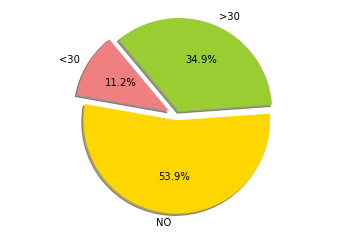

In [38]:
#Target Variable distribution
labels = ['NO', '>30' ,'<30']
sizes = df["readmitted"].value_counts()
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.05, 0.05, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=170)

plt.axis('equal')
plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   time_in_hospital          101766 non-null  int64
 1   num_lab_procedures        101766 non-null  int64
 2   num_procedures            101766 non-null  int64
 3   num_medications           101766 non-null  int64
 4   number_outpatient         101766 non-null  int64
 5   number_emergency          101766 non-null  int64
 6   number_inpatient          101766 non-null  int64
 7   number_diagnoses          101766 non-null  int64
 8   race                      101766 non-null  int32
 9   gender                    101766 non-null  int32
 10  age                       101766 non-null  int32
 11  diag_1                    101766 non-null  int32
 12  diag_2                    101766 non-null  int32
 13  diag_3                    101766 non-null  int32
 14  max_glu_serum       

In [40]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers  

In [41]:
# list of all column names
list_headers = list(df.columns) 

In [42]:
List_Outliers_to_drop = detect_outliers(df,5,list_headers)
#prints the outlier recorts
df.loc[List_Outliers_to_drop] 

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2044,14,71,6,35,0,0,0,9,3,1,8,264,246,667,2,1,2,1,1,1,1,0,0,1,0,1,2,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1
3978,13,60,0,27,0,0,1,7,3,0,6,709,319,530,2,3,2,1,1,1,1,0,1,2,0,3,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,2
4365,14,64,1,29,0,0,0,9,1,0,8,326,314,4,2,0,2,1,1,1,1,0,3,2,0,1,1,1,1,0,0,0,0,2,1,0,0,0,0,0,1,0
5587,14,91,6,46,0,0,0,9,3,1,7,122,465,460,2,1,0,1,1,1,1,0,1,2,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,2
6206,14,60,1,25,0,0,0,8,1,1,6,280,134,534,2,1,2,1,1,1,1,0,1,2,0,1,2,1,1,0,0,0,0,3,1,0,0,0,0,0,1,1
6424,13,51,3,22,0,0,0,9,1,1,4,122,486,252,2,1,2,1,1,1,1,0,2,2,0,1,2,1,1,0,0,0,0,1,1,0,0,0,0,0,1,2
6930,14,56,0,12,0,0,2,6,1,0,6,163,79,247,2,1,0,1,1,1,1,0,2,2,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,1
8172,14,77,6,37,1,1,2,9,3,0,5,237,468,503,2,2,1,1,1,1,1,0,1,1,0,1,2,1,1,0,0,0,0,2,1,0,0,0,0,0,1,1
12314,14,68,6,61,0,0,0,9,1,1,6,264,247,668,2,2,2,1,1,1,1,0,1,0,0,1,2,1,1,0,0,0,0,2,1,0,0,0,0,0,1,2
13163,13,129,5,45,1,1,1,8,3,0,8,277,386,249,2,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1


In [43]:
#drop outliers
df = df.drop(List_Outliers_to_drop, axis = 0).reset_index(drop=True)

In [44]:
df.shape

(101270, 42)

In [46]:
#both features citoglipton and examide contain only one value so I will drop them. 
sizes1 = df["citoglipton"].value_counts()
sizes2 = df["examide"].value_counts()


In [47]:
print("Count citoglipton: ", sizes1,"\n \nCount examide: ", sizes2)
df.drop(["examide","citoglipton"], axis=1, inplace=True)  

Count citoglipton:  0    101270
Name: citoglipton, dtype: int64 
 
Count examide:  0    101270
Name: examide, dtype: int64


# 3.Understanding the relationship(s), or lack of, between variables 

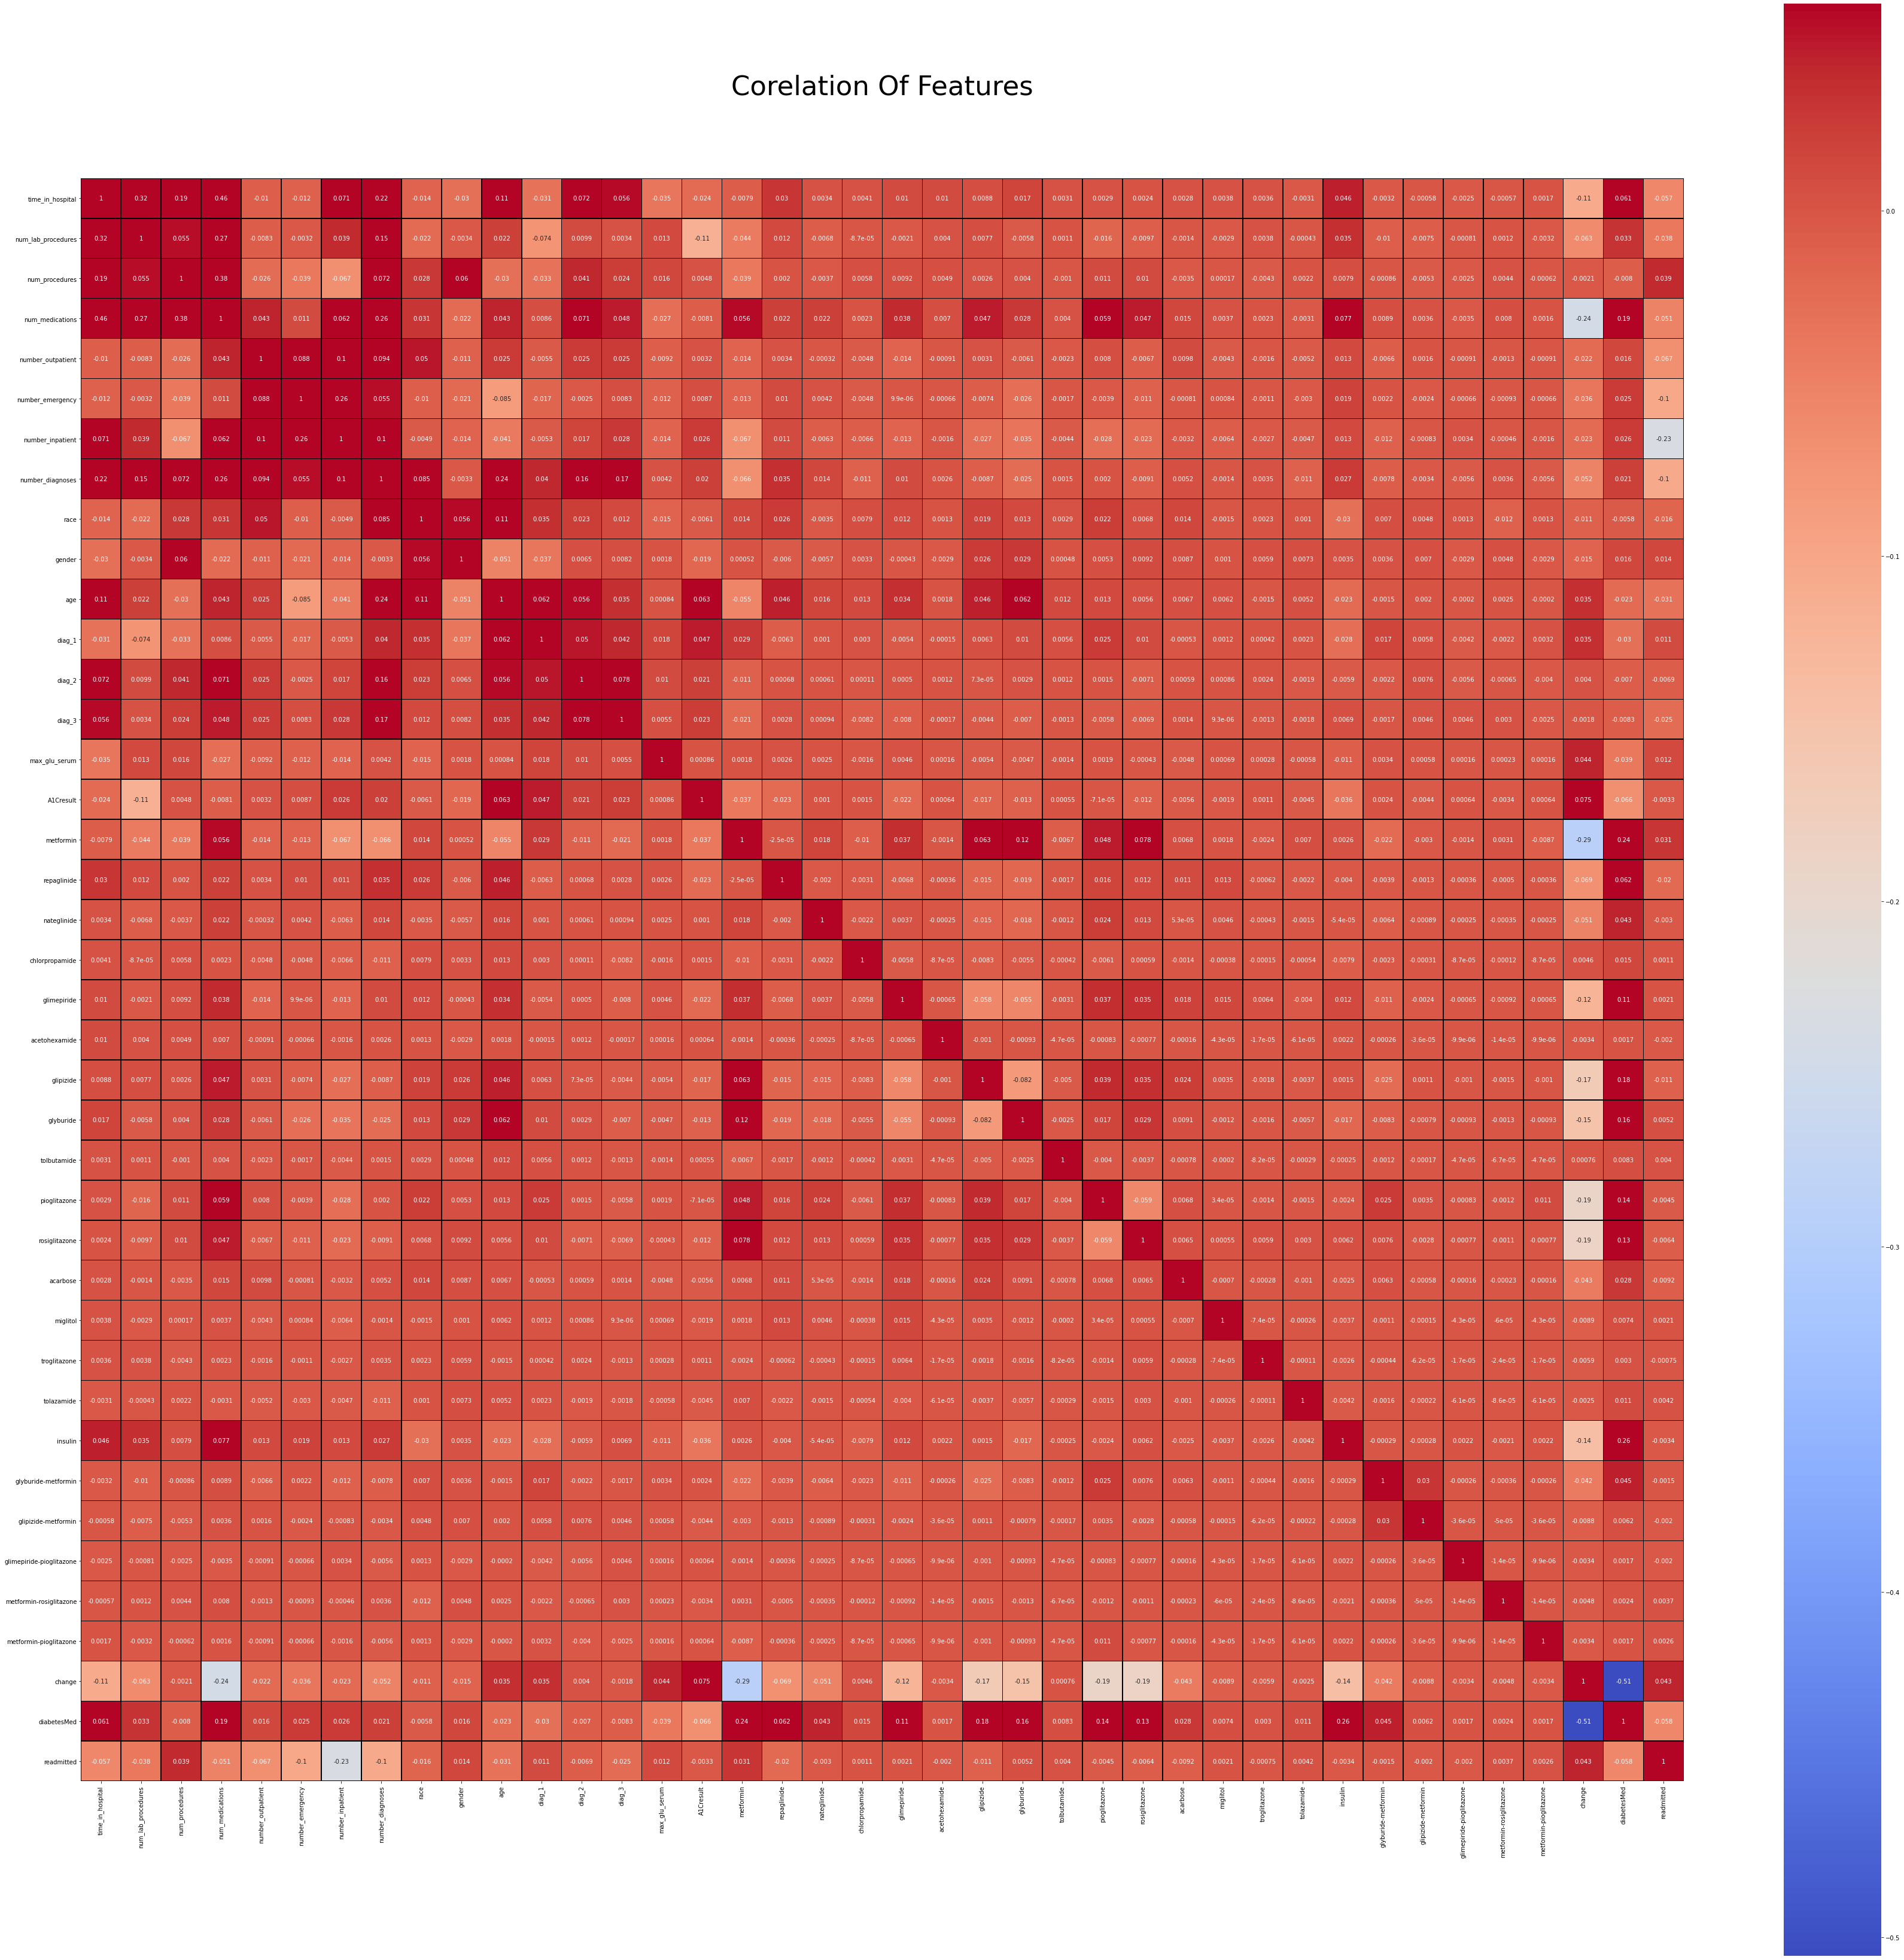

In [48]:
#corelation heatmap:
fig, ax = plt.subplots(figsize=(60,60))  
plt.title('Corelation Of Features',y=1.05, size = 45)
_ = sns.heatmap(df.corr(),cmap='coolwarm',vmax = 0.06, square = True, linecolor ='black', annot = True,linewidths = 0.5,ax = ax, xticklabels=True, yticklabels=True)


# 4.Implementing Genetic algorithm for Feature selection

In [49]:
#defining various steps required for the genetic algorithm
#generates the initial population
def gen_inital_pop(population_size : int, numb_feat: int):
    population = []
    for i in range(population_size):
        chromosome = np.ones(numb_feat,dtype=np.bool)
        chromosome[:int(0.3*numb_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population,X_train,y_train,pred_model):
    scores = []
    model = pred_model
    for chromosome in population:
        model.fit(X_train.iloc[:,chromosome],y_train)
        predictions = model.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(y_test,predictions))
        #implementation for RepeatedKFold
        #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        #cross_score = cross_val_score(model, X_train.iloc[:,chromosome], y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        #mean_scores = np.mean(cross_score)
        #scores.append(mean_scores)
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])


def tournament(population: list,fitnessScores: list):
    population_size = len(fitnessScores)
    #select 3 individuals at random k =3 by the instructions !!!!
    choice_1 = r.randint(0, population_size-1)
    choice_2 = r.randint(0, population_size-1)
    choice_3 = r.randint(0, population_size-1)
    #print(choice_1,choice_2,choice_3)
    Dict ={choice_1:fitnessScores[choice_1],
           choice_2:fitnessScores[choice_2],
           choice_3:fitnessScores[choice_3],
           }
    indexOfIndividualHighestScore = max(Dict, key = lambda x: Dict[x])
    return population[indexOfIndividualHighestScore]


def breed_crossover(parent_1: list, parent_2: list):
    # Get length of chromosome
    chromosome_length = len(parent_1)

    #Recombination: one-point crossover with probability 0.7
    crossover_probability = r.uniform(0, 1)
    if(crossover_probability > 0.7):
        child_1 = parent_1
        child_2 = parent_2
        return child_1, child_2
    
    # Pick crossover point
    crossover_point = r.randint(1,chromosome_length-1)
    parent_1=list(parent_1)
    parent_2=list(parent_2)
    child_1 = parent_1[:crossover_point] + parent_2[crossover_point:] 
    child_2 = parent_2[:crossover_point] + parent_1[crossover_point:] 

    return child_1, child_2

def mutation(population, mutation_probability: float):
    #length of the population
    for x in range(len(population)):
        #length of the chromosomes for each individual
        for i in range(len(population[x])):
            mutation_mask= r.uniform(0, 1)
            
            #if the generated number is less that Pm the gene will be mutated(flipped)
            if(mutation_mask < mutation_probability):
                if(population[x][i] == True):
                    population[x][i] = False
                else:
                    population[x][i] = True
    return population  


def survivor_selection(parent_population, offspring_population,X_train,y_train):
    score, feat = fitness_score(parent_population,X_train,y_train,model)
    best =[]

    score, feat = fitness_score(parent_population,X_train,y_train,model)
    best = feat[0]
    offspring_population[len(offspring_population)-1] = best
    score1, feat = fitness_score(offspring_population, X_train, y_train,model)
    return offspring_population


In [50]:
def runModel(X_train, X_test, y_train, y_test, num_feat, population_size, generation_size, mutation_probability,model):
    list_best_score =[]
    list_average_score = []
    list_worst_score =[]
    print('{:<8s}{:<8}'.format("GEN","SCORE"))
    current_population = gen_inital_pop(population_size, num_feat)
    for x in range(generation_size):    
        fitnessScores_, features =  fitness_score(current_population,X_train,y_train,model) 
        print("{:<8d}{:<8.4f}".format(x+1,np.max(fitnessScores_)))
    
        #for plotting
        list_best_score.append(np.max(fitnessScores_))
        list_average_score.append(np.average(fitnessScores_))
        list_worst_score.append(np.min(fitnessScores_))
        
        #create an empty list for the new population
        new_population = []
        for i in range(int(population_size/2)):
            parent_1_ = tournament(features,fitnessScores_)
            parent_2_ = tournament(features,fitnessScores_)
            child_1_, child_2_ = breed_crossover(parent_1_,parent_2_)
            new_population.append(child_1_)
            new_population.append(child_2_)
        
        new_population = mutation(new_population,mutation_probability)
        current_population = survivor_selection(current_population,new_population,X_train,y_train)
    # Plot best, average and worst
    import matplotlib.pyplot as plt
    plt.plot(list_best_score)
    plt.xlabel('Generation')
    plt.ylabel('Fitness Value')
    plt.show()
  
    best_score, best_features =  fitness_score(current_population,X_train,y_train,model) 
    return best_score, best_features

# 5. Preparing the data for modeling

### 5.1. Splitting the data into feature / target matrices / data scaling

In [51]:
array = np.array(df.values)

In [52]:
X = array[:,:-1]
y = array[:,-1]

In [53]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [54]:
print(X.shape)
print(y.shape)

(101270, 39)
(101270,)


In [55]:
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,1,41,0,1,0,0,0,1,3,0,0,125,0,0,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,1,1,0,0,0,0,1,0,2
1,3,59,0,18,0,0,0,9,3,0,1,144,80,122,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,0,1,1
2,2,11,5,13,2,0,1,6,1,0,2,455,79,767,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,1,1,0,0,0,0,1,1,2
3,2,44,1,16,0,0,0,7,3,1,3,555,98,249,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,0,1,2
4,1,51,0,8,0,0,0,5,3,1,4,55,25,87,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,2,1,0,0,0,0,0,1,2


In [56]:
col = list(df.columns)
print(col)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


In [57]:
col = col[:-1]

In [58]:
print(col)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [59]:
df = pd.DataFrame(X,columns=col)

In [60]:
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,-1.000,-0.389,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.200,-1.000,-1.000,-0.651,-1.000,-1.000,0.333,0.333,-0.333,-0.333,-0.333,-0.333,-0.333,-1.000,-0.333,-0.333,-1.000,-0.333,-0.333,-0.333,-0.333,-1.000,-1.000,-0.333,-0.333,-1.000,-1.000,-1.000,-1.000,1.000,-1.000
1,-0.692,-0.115,-1.000,-0.575,-1.000,-1.000,-1.000,0.067,0.200,-1.000,-0.778,-0.598,-0.786,-0.691,0.333,0.333,-0.333,-0.333,-0.333,-0.333,-0.333,-1.000,-0.333,-0.333,-1.000,-0.333,-0.333,-0.333,-0.333,-1.000,-1.000,1.000,-0.333,-1.000,-1.000,-1.000,-1.000,-1.000,1.000
2,-0.846,-0.847,0.667,-0.700,-0.905,-1.000,-0.905,-0.333,-0.600,-1.000,-0.556,0.271,-0.789,0.944,0.333,0.333,-0.333,-0.333,-0.333,-0.333,-0.333,-1.000,0.333,-0.333,-1.000,-0.333,-0.333,-0.333,-0.333,-1.000,-1.000,-0.333,-0.333,-1.000,-1.000,-1.000,-1.000,1.000,1.000
3,-0.846,-0.344,-0.667,-0.625,-1.000,-1.000,-1.000,-0.200,0.200,0.000,-0.333,0.550,-0.738,-0.369,0.333,0.333,-0.333,-0.333,-0.333,-0.333,-0.333,-1.000,-0.333,-0.333,-1.000,-0.333,-0.333,-0.333,-0.333,-1.000,-1.000,1.000,-0.333,-1.000,-1.000,-1.000,-1.000,-1.000,1.000
4,-1.000,-0.237,-1.000,-0.825,-1.000,-1.000,-1.000,-0.467,0.200,0.000,-0.111,-0.846,-0.933,-0.779,0.333,0.333,-0.333,-0.333,-0.333,-0.333,-0.333,-1.000,0.333,-0.333,-1.000,-0.333,-0.333,-0.333,-0.333,-1.000,-1.000,0.333,-0.333,-1.000,-1.000,-1.000,-1.000,-1.000,1.000


### 5.2. Splitting the data in train test samples for feature selection algorithms

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.30, random_state=42)

In [62]:
X_train.shape , y_train.shape, X_test.shape, y_test.shape

((70889, 39), (70889,), (30381, 39), (30381,))

### 5.3. Executing the model for default target

### 5.3.1 Running the model before implementing GA

In [63]:
time1 = time()
model = LogisticRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print("Accuracy before implementation of GA= "+ str(accuracy_score(y_test,predictions)))
time2 = time()
print('Time: {}'.format(time2-time1))

Accuracy before implementation of GA= 0.569566505381653
Time: 4.457080364227295


### 5.3.2 Model evaluation before implementing GA

In [64]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[   25   954  2467]
 [   19  2397  8059]
 [    5  1573 14882]]


In [65]:
matrix = metrics.classification_report(y_test, predictions, digits=4)
print(matrix)

              precision    recall  f1-score   support

           0     0.5102    0.0073    0.0143      3446
           1     0.4868    0.2288    0.3113     10475
           2     0.5857    0.9041    0.7109     16460

    accuracy                         0.5696     30381
   macro avg     0.5276    0.3801    0.3455     30381
weighted avg     0.5430    0.5696    0.4941     30381



### 5.3.3 Implementing GA for feature selection

GEN     SCORE   
1       0.5713  
2       0.5715  
3       0.5719  
4       0.5719  
5       0.5725  
6       0.5725  
7       0.5725  
8       0.5733  
9       0.5733  
10      0.5733  
11      0.5733  
12      0.5733  
13      0.5733  
14      0.5733  
15      0.5733  
16      0.5733  
17      0.5733  
18      0.5733  
19      0.5733  
20      0.5733  
21      0.5733  
22      0.5733  
23      0.5733  
24      0.5733  
25      0.5733  
26      0.5733  
27      0.5733  
28      0.5733  
29      0.5733  
30      0.5733  
31      0.5733  
32      0.5733  
33      0.5733  
34      0.5733  
35      0.5733  
36      0.5733  
37      0.5733  
38      0.5733  
39      0.5733  
40      0.5733  
41      0.5733  
42      0.5733  
43      0.5733  
44      0.5733  
45      0.5733  
46      0.5733  
47      0.5733  
48      0.5733  
49      0.5733  
50      0.5733  


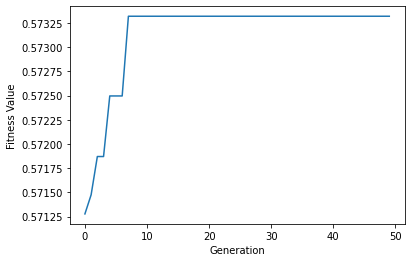

Time: 28273.625595331192


In [66]:
time1 = time()
num_feat = 39
population_size = 50
mutation_probability = 0.1
generation_size = 50
model = LogisticRegression()
best_score, best_features = runModel(X_train, X_test, y_train, y_test, num_feat, population_size, generation_size, mutation_probability,model)
time2 = time()
print('Time: {}'.format(time2-time1))

In [67]:
print(best_score)

[0.5733188505974128, 0.5716730851519042, 0.5716401698429939, 0.5715414239162635, 0.571442677989533, 0.5712122708271617, 0.5712122708271617, 0.5711793555182515, 0.5711135249004312, 0.5711135249004312, 0.5710476942826108, 0.57088311773806, 0.5708172871202396, 0.5708172871202396, 0.5705868799578684, 0.5705868799578684, 0.5705868799578684, 0.5705539646489582, 0.5705210493400481, 0.5705210493400481, 0.5704552187222277, 0.5704223034133176, 0.570323557486587, 0.570323557486587, 0.5702248115598565, 0.5701589809420361, 0.5701589809420361, 0.5700931503242158, 0.5700602350153057, 0.5699285737796649, 0.5698956584707547, 0.5698298278529343, 0.5697969125440242, 0.5697639972351141, 0.5697639972351141, 0.5696652513083835, 0.5696652513083835, 0.5695994206905631, 0.5695006747638327, 0.5693360982192818, 0.5692373522925512, 0.5689740298212699, 0.5688094532767191, 0.5687436226588987, 0.5687107073499885, 0.568447384878707, 0.5682498930252461, 0.5519568151147098, 0.5513972548632369, 0.5440242256673579]


In [68]:
#print best features
print(X_train.iloc[:,best_features[0]].columns)

Index(['num_lab_procedures', 'num_procedures', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'tolbutamide', 'rosiglitazone', 'miglitol', 'glyburide-metformin', 'glimepiride-pioglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'], dtype='object')


### 5.3.4 Running the model with the filtered features

In [69]:
X_train = X_train.iloc[:,best_features[0]]
X_test = X_test.iloc[:,best_features[0]]

In [70]:
time1 = time()
model = LogisticRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print("Accuracy before implementation of GA= "+ str(accuracy_score(y_test,predictions)))
time2 = time()
print('Time: {}'.format(time2-time1))

Accuracy before implementation of GA= 0.5733188505974128
Time: 3.1116766929626465


### 5.3.5 Model evaluation after implementing GA

In [71]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[   43   962  2441]
 [   35  2474  7966]
 [    7  1552 14901]]


In [72]:
matrix = metrics.classification_report(y_test, predictions,digits=4)
print(matrix)

              precision    recall  f1-score   support

           0     0.5059    0.0125    0.0244      3446
           1     0.4960    0.2362    0.3200     10475
           2     0.5888    0.9053    0.7135     16460

    accuracy                         0.5733     30381
   macro avg     0.5302    0.3846    0.3526     30381
weighted avg     0.5474    0.5733    0.4997     30381



### 5.4. Executing the model for a binary target

In [73]:
#recode the targer values 
for i in range(len(y)):
    if(y[i] == 0):
        y[i] = 1

In [74]:
#y.value_counts()
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[    1 46621]
 [    2 54649]]


In [75]:
#run the model for binary classification 1:readmitted 2:not-readmitted 
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.30, random_state=42)

In [76]:
X_train.shape , y_train.shape, X_test.shape, y_test.shape

((70889, 39), (70889,), (30381, 39), (30381,))

### 5.4.1 Running the model before implementing GA

In [77]:
time1 = time()
model = LogisticRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print("Accuracy before implementation of GA= "+ str(accuracy_score(y_test,predictions)))
time2 = time()
print('Time: {}'.format(time2-time1))

Accuracy before implementation of GA= 0.6186432309667226
Time: 0.8776519298553467


### 5.4.2 Model evaluation before implementing GA

In [78]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[ 5530  8391]
 [ 3195 13265]]


In [79]:
matrix = metrics.classification_report(y_test, predictions,digits=4)
print(matrix)

              precision    recall  f1-score   support

           1     0.6338    0.3972    0.4884     13921
           2     0.6125    0.8059    0.6960     16460

    accuracy                         0.6186     30381
   macro avg     0.6232    0.6016    0.5922     30381
weighted avg     0.6223    0.6186    0.6009     30381



### 5.4.3 Implementing GA for feature selection

GEN     SCORE   
1       0.6204  
2       0.6206  
3       0.6206  
4       0.6206  
5       0.6206  
6       0.6209  
7       0.6209  
8       0.6212  
9       0.6221  
10      0.6221  
11      0.6221  
12      0.6221  
13      0.6221  
14      0.6222  
15      0.6222  
16      0.6224  
17      0.6224  
18      0.6224  
19      0.6224  
20      0.6224  
21      0.6224  
22      0.6224  
23      0.6224  
24      0.6224  
25      0.6226  
26      0.6226  
27      0.6226  
28      0.6226  
29      0.6226  
30      0.6226  
31      0.6226  
32      0.6226  
33      0.6226  
34      0.6226  
35      0.6226  
36      0.6226  
37      0.6226  
38      0.6226  
39      0.6226  
40      0.6226  
41      0.6226  
42      0.6226  
43      0.6226  
44      0.6226  
45      0.6226  
46      0.6226  
47      0.6226  
48      0.6226  
49      0.6226  
50      0.6226  


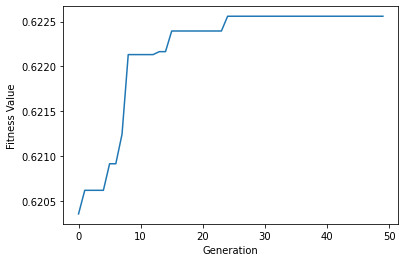

Time: 6338.21190738678


In [80]:
time1 = time()
num_feat = 39
population_size = 50
mutation_probability = 0.05
generation_size = 50
model = LogisticRegression()
best_score, best_features = runModel(X_train, X_test, y_train, y_test, num_feat, population_size, generation_size, mutation_probability,model)
time2 = time()
print('Time: {}'.format(time2-time1))

In [81]:
print(best_score)

[0.6225601527270334, 0.6223297455646621, 0.6220993384022909, 0.6216714393864586, 0.6216714393864586, 0.6214081169151773, 0.621375201606267, 0.6212764556795366, 0.620980217899345, 0.6209473025904348, 0.6209473025904348, 0.6209473025904348, 0.6209473025904348, 0.6209473025904348, 0.6209473025904348, 0.6208814719726145, 0.6208485566637043, 0.6208156413547942, 0.6207827260458839, 0.6206839801191534, 0.6206839801191534, 0.6206181495013331, 0.6205194035746026, 0.6204864882656924, 0.6204535729567822, 0.6203548270300516, 0.6203548270300516, 0.6202889964122313, 0.6201573351765907, 0.6201244198676804, 0.6200585892498601, 0.62002567394095, 0.62002567394095, 0.6199927586320397, 0.6199927586320397, 0.6198940127053092, 0.619861097396399, 0.6196965208518482, 0.6194990289983872, 0.6193673677627465, 0.6192027912181955, 0.6188078075112735, 0.6185115697310819, 0.6183799084954412, 0.6182811625687107, 0.6177216023172377, 0.6176557716994174, 0.5800006583061782, 0.579770251143807, 0.5793423521279747]


In [82]:
#print best features
print(X_train.iloc[:,best_features[0]].columns)

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'race', 'gender', 'diag_2', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'rosiglitazone', 'tolazamide', 'insulin', 'glipizide-metformin', 'metformin-rosiglitazone', 'diabetesMed'], dtype='object')


### 5.4.4 Running the model with the filtered features

In [83]:
X_train = X_train.iloc[:,best_features[0]]
X_test = X_test.iloc[:,best_features[0]]

In [84]:
time1 = time()
model = LogisticRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print("Accuracy before implementation of GA= "+ str(accuracy_score(y_test,predictions)))
time2 = time()
print('Time: {}'.format(time2-time1))

Accuracy before implementation of GA= 0.6225601527270334
Time: 0.9414806365966797


### 5.4.5 Model evaluation after implementing GA

In [85]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[ 5519  8402]
 [ 3065 13395]]


In [86]:
matrix = metrics.classification_report(y_test, predictions,digits=4)
print(matrix)

              precision    recall  f1-score   support

           1     0.6429    0.3965    0.4905     13921
           2     0.6145    0.8138    0.7003     16460

    accuracy                         0.6226     30381
   macro avg     0.6287    0.6051    0.5954     30381
weighted avg     0.6276    0.6226    0.6041     30381

